#Partie 1 : Collecte et Préparation des Données

## a) Collecte des données

Données Yahoo Finance

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime

# Générer la date d'aujourd'hui sous le format '2014-01-01'
today = datetime.today().strftime('%Y-%m-%d')
before5=(datetime.today()-pd.DateOffset(years=5)).strftime('%Y-%m-%d')  ## On prend un historique de 5 ans

sp500_data = yf.download('^GSPC', start=before5, end=today, progress=False)
sp500_data.columns = sp500_data.columns.droplevel(1)

sp500_data = sp500_data[['Adj Close','Volume']]
sp500_data = sp500_data.rename(columns={'Adj Close': 'SP500', 'Volume': 'Volume'})
sp500_data.index = sp500_data.index.strftime('%Y-%m-%d')


VIX_data = yf.download('^VIX', start=before5, end=today, progress=False)
VIX_data.columns = VIX_data.columns.droplevel(1)

VIX_data = VIX_data['Adj Close']
VIX_data = VIX_data.rename('VIX')
VIX_data.index = VIX_data.index.strftime('%Y-%m-%d')

sp500_data

Price,SP500,Volume
Date,,
2020-01-07,3237.179932,3435910000
2020-01-08,3253.050049,3726840000
2020-01-09,3274.699951,3641230000
2020-01-10,3265.350098,3214580000
2020-01-13,3288.129883,3459390000
...,...,...
2024-12-30,5906.939941,3433250000
2024-12-31,5881.629883,3128350000
2025-01-02,5868.549805,3621680000


Données FRED ( Federal Reserve Bank of st.Louis)

In [ ]:
pip install fredapi

In [ ]:
from fredapi import Fred
import matplotlib.pyplot as plt
import datetime


fred = Fred(api_key='539eb692aa5fe7f6b14e6ac8891de230')

# Les séries de données FRED pour les taux d'intérêt des obligations américaines
series_ids = {
    "3M": "DGS3MO",
    "1Y": "DGS1",
    "5Y": "DGS5",
    "10Y": "DGS10",
    "30Y": "DGS30",
    "Inflation": "CPIAUCSL",
    "GDP": "GDP",
    "Unenployment": "UNRATE"
}


start_date = datetime.datetime(2019, 12, 1)
end_date = datetime.datetime(2024, 12, 1)

data = {}
for maturity, series_id in series_ids.items():
    data[maturity] = fred.get_series(series_id, start_date, end_date)

# Convertir les données en DataFrame pandas
macro_data = pd.DataFrame(data)

#Pour GDP, Inflation et Unenmployment, de période mensuelle ou trimestrielle, propager la dernière valeur connue
macro_data = macro_data.ffill()

In [ ]:
macro_data.head()

,3M,1Y,5Y,10Y,30Y,Inflation,GDP,Unenployment
2019-10-01,NaN,NaN,NaN,NaN,NaN,NaN,21933.217,NaN
2019-12-01,NaN,NaN,NaN,NaN,NaN,258.63,21933.217,3.6
2019-12-02,1.60,1.60,1.65,1.83,2.28,258.63,21933.217,3.6
2019-12-03,1.57,1.57,1.54,1.72,2.17,258.63,21933.217,3.6
2019-12-04,1.55,1.56,1.60,1.77,2.22,258.63,21933.217,3.6


## b) Prétraitement des données


In [ ]:
# Concaténer toutes les dataframes
date_format = '%Y-%m-%d'
macro_data.index = pd.to_datetime(macro_data.index).strftime(date_format)

df = pd.concat([sp500_data, VIX_data, macro_data], axis = 1)
df.head()

,SP500,Volume,VIX,3M,1Y,5Y,10Y,30Y,Inflation,GDP,Unenployment
2020-01-07,3237.179932,3.435910e+09,13.79,1.54,1.53,1.62,1.83,2.31,258.906,21727.657,3.6
2020-01-08,3253.050049,3.726840e+09,13.45,1.54,1.55,1.67,1.87,2.35,258.906,21727.657,3.6
2020-01-09,3274.699951,3.641230e+09,12.54,1.54,1.54,1.65,1.85,2.38,258.906,21727.657,3.6
2020-01-10,3265.350098,3.214580e+09,12.56,1.54,1.53,1.63,1.83,2.28,258.906,21727.657,3.6
2020-01-13,3288.129883,3.459390e+09,12.32,1.57,1.53,1.65,1.85,2.30,258.906,21727.657,3.6


Retirer les NAN

In [ ]:
# Enlever les valeurs NAN :
print("Nombre de lignes avant : ", df.shape[0])
df_cleaned = df.dropna()
print("Nombre de lignes après : ", df_cleaned.shape[0])

Nombre de lignes avant :  1346
Nombre de lignes après :  1234


Retirer les valeurs aberrantes

In [ ]:
def remove_outliers(df):

  '''Retirer les outliers'''

  # Compter le nombre initial de lignes
  initial_rows = len(df)

  # Calcul du Z-scores (Calcul à quel point la valeur est éloignée de la moyenne (en nombre d'écart type))
  z = np.abs(stats.zscore(df))
  # Create a mask for rows where any value has a Z-score greater than 5
  mask = (z > 5).any(axis=1)
  # Retirer les lignes contenant des outliers
  df_no_outliers = df[~mask]

  # Compter le nombre de lignes après nettoyage
  cleaned_rows = len(df_no_outliers)
  rows_removed = initial_rows - cleaned_rows
  print(f"Outliers supprimées : {rows_removed}")

  return df_no_outliers

In [ ]:
df_cleaned = remove_outliers(df_cleaned)

Outliers supprimées : 9


In [ ]:
df_final = df_cleaned.sort_index(ascending = True)
df_final.tail(6)

,SP500,Volume,VIX,3M,1Y,5Y,10Y,30Y,Inflation,GDP,Unenployment
2024-11-21,5948.709961,4.230120e+09,16.870001,4.63,4.39,4.30,4.43,4.61,316.441,29374.914,4.2
2024-11-22,5969.339844,4.141420e+09,15.240000,4.63,4.42,4.30,4.41,4.60,316.441,29374.914,4.2
2024-11-25,5987.370117,5.633150e+09,14.600000,4.62,4.37,4.17,4.27,4.45,316.441,29374.914,4.2
2024-11-26,6021.629883,3.835170e+09,14.100000,4.61,4.37,4.17,4.30,4.48,316.441,29374.914,4.2
2024-11-27,5998.740234,3.363340e+09,14.100000,4.60,4.34,4.11,4.25,4.44,316.441,29374.914,4.2
2024-11-29,6032.379883,2.444420e+09,13.510000,4.58,4.30,4.05,4.18,4.36,316.441,29374.914,4.2


Calcul des returs normaux

In [ ]:
df_final['SP500_returns'] = df_final['SP500'].pct_change()
#df_final.drop(columns=['SP500'], inplace=True)  # Supprimer l'ancienne colonne si besoin


Calcul des log-returns

In [ ]:
df_final['SP500_Logreturns']= np.log(df_final['SP500']/df_final['SP500'].shift(1))

df_final = df_final.iloc[1:] # retirer le Nan sur la première ligne

data_reg = df_final.copy()
data_reg = data_reg.drop(columns = ['SP500_returns'])

df_final.tail(6)

,SP500,Volume,VIX,3M,1Y,5Y,10Y,30Y,Inflation,GDP,Unenployment,SP500_returns,SP500_Logreturns
2024-11-21,5948.709961,4.230120e+09,16.870001,4.63,4.39,4.30,4.43,4.61,316.441,29374.914,4.2,0.005340,0.005326
2024-11-22,5969.339844,4.141420e+09,15.240000,4.63,4.42,4.30,4.41,4.60,316.441,29374.914,4.2,0.003468,0.003462
2024-11-25,5987.370117,5.633150e+09,14.600000,4.62,4.37,4.17,4.27,4.45,316.441,29374.914,4.2,0.003020,0.003016
2024-11-26,6021.629883,3.835170e+09,14.100000,4.61,4.37,4.17,4.30,4.48,316.441,29374.914,4.2,0.005722,0.005706
2024-11-27,5998.740234,3.363340e+09,14.100000,4.60,4.34,4.11,4.25,4.44,316.441,29374.914,4.2,-0.003801,-0.003808
2024-11-29,6032.379883,2.444420e+09,13.510000,4.58,4.30,4.05,4.18,4.36,316.441,29374.914,4.2,0.005608,0.005592


In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
def adf_test(timeseries):
    print ('Résultats du test de Dickey-Fuller augmenté :')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Statistique du test', 'Valeur p', 'Décalages utilisés', 'Nombre d’observations utilisées'])
    for key,value in dftest[4].items():
       dfoutput['Valeur critique (%s)' % key] = value
    print (dfoutput)

In [ ]:
adf_test(df_final['SP500_returns'])

P-value << 0..05, nous rejetons l'hypothèse nulle et concluons que la série est stationnaire.
Décalages utilisés: 23

In [ ]:
adf_test(df_final['SP500_Logreturns'])

In [ ]:
df_final['SP500_Logreturns'].plot(figsize = (13,2))

Pour les log returns: P-value << 0.05 nous rejetons l'hypothèse nulle => la série des log returns est stationnaire. Cohérent avec le graphique ci-dessus



In [ ]:
import matplotlib.dates as mdates

# Convertir l'index en objets datetime
df_final.index = pd.to_datetime(df_final.index)

fig, ax = plt.subplots(figsize=(12, 3))

ax.plot(df_final.index, df_final['SP500_returns'])
ax.set_title('Série temporelle des rendements du SP500')
ax.set_xlabel('Date')
ax.set_ylabel('Rendements')
ax.grid(True)

# Configurer les dates en abscisse
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

fig.autofmt_xdate()

plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_final['SP500_returns'].dropna(), lags=20)
plt.show()

plot_pacf(df_final['SP500_returns'].dropna(), lags=20)
plt.show()

Dans les 2 graphes, seul le 1er lag est significatif. Cela suggère à première vu un modèle AR(1).

## c) Feature engineering

In [ ]:
# Moyennes mobiles
df_final['MA_20'] = df_final['SP500_returns'].rolling(window=20).mean()
df_final['MA_50'] = df_final['SP500_returns'].rolling(window=50).mean()

# RSI
def calculate_rsi(data, period=14):
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df_final['RSI'] = calculate_rsi(df_final['SP500_returns'])

# MACD
def calculate_macd(data, short_period=12, long_period=26, signal_period=9):
    short_ema = data.ewm(span=short_period, adjust=False).mean()
    long_ema = data.ewm(span=long_period, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    histogram = macd - signal
    return macd, signal, histogram

df_final['MACD'], df_final['MACD_Signal'], df_final['MACD_Histogram'] = calculate_macd(df_final['SP500_returns'])

df_final.head()

,SP500,Volume,VIX,3M,1Y,5Y,10Y,30Y,Inflation,GDP,Unenployment,SP500_returns,SP500_Logreturns,MA_20,MA_50,RSI,MACD,MACD_Signal,MACD_Histogram
2020-01-09,3274.699951,3.641230e+09,12.54,1.54,1.54,1.65,1.85,2.38,258.906,21727.657,3.6,0.006655,0.006633,NaN,NaN,NaN,0.000000,0.000000,0.000000
2020-01-10,3265.350098,3.214580e+09,12.56,1.54,1.53,1.63,1.83,2.28,258.906,21727.657,3.6,-0.002855,-0.002859,NaN,NaN,NaN,-0.000759,-0.000152,-0.000607
2020-01-13,3288.129883,3.459390e+09,12.32,1.57,1.53,1.65,1.85,2.30,258.906,21727.657,3.6,0.006976,0.006952,NaN,NaN,NaN,-0.000560,-0.000233,-0.000327
2020-01-14,3283.149902,3.687620e+09,12.39,1.57,1.53,1.63,1.82,2.27,258.906,21727.657,3.6,-0.001515,-0.001516,NaN,NaN,NaN,-0.001076,-0.000402,-0.000674
2020-01-15,3289.290039,3.721490e+09,12.42,1.57,1.54,1.60,1.79,2.23,258.906,21727.657,3.6,0.001870,0.001868,NaN,NaN,NaN,-0.001197,-0.000561,-0.000636


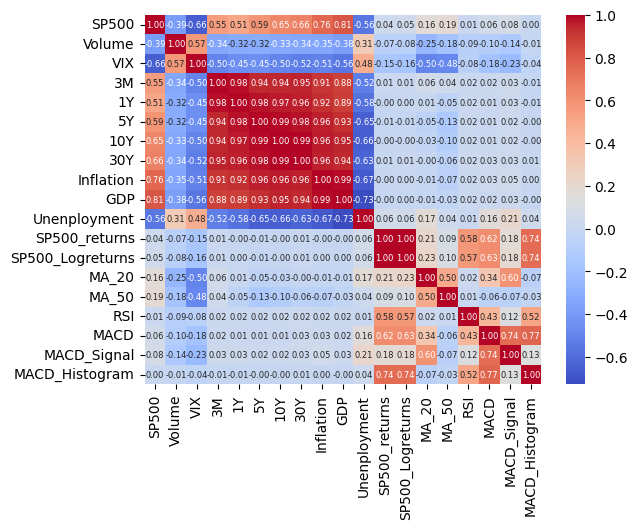

In [ ]:
import seaborn as sns

correlation_matrix = df_final.corr()

# HeatMap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', annot_kws={"size": 6}, fmt=".2f")
plt.show()

# Partie 2 : Développement du Modèle Prédictif

In [ ]:
import sklearn as sk

### Régression linéaire


Nous allons ci-dessous construire un modèle de régression linéaire afin de prédire les rendements du S&P500 à partir des autres variables de notre base de donnée.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


# Définir les features (X) et la target (y)
X = data_reg.drop(columns=['SP500_Logreturns'])  # Toutes les colonnes sauf les rendements
y = data_reg['SP500_Logreturns']  # Rendements du S&P 500

# Diviser les données en jeux d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Standardiser les features (important pour les variables macroéconomiques)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Construire et entraîner le modèle de régression linéaire
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Faire des prédictions
y_pred = model.predict(X_test_scaled)

# Évaluer le modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R²:", r2)

# Afficher les coefficients du modèle
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

print(coefficients)


MSE: 5.7681203387994996e-05
R²: 0.0466612775291817
         Feature  Coefficient
5             5Y     0.035698
7            30Y     0.034241
9            GDP     0.003540
10  Unenployment     0.003308
4             1Y     0.000751
1         Volume     0.000607
8      Inflation    -0.000246
0          SP500    -0.001175
2            VIX    -0.005259
3             3M    -0.008634
6            10Y    -0.064505


Le MSE est faible. Cependant, cela ne permet pas de juger réellement notre modèle de prédiction, car les log-rendements journaliers sont par nature très petits, et donc les écarts à la réalité également. Le R2 nous permettra d'avoir un avis plus précis sur notre modèle.

R2 = 0.0467, ce qui signifie que seulement 4.67% de la variance de nos rendements est expliquée par nos variables indépendantes. Cela est très faible.

On peut donc conclure que le modèle linéaire n'est pas précis et ne permet pas de prédire efficacement nos rendements. Ce qui est logique, car en finance les rendements sont très volatiles et ne peuvent pas être décrits par des modèles linéaires simples.

### Random Forest Classifier


Random forest classifier => va prédire si le prix va augmenter ou diminuer = Hausse ou Baisse

In [ ]:
## Création d'un booléen: 0 si Baisse le jour suivant;  1 si Hausse le jour suivant
df_final['Predictor'] = (df_final['SP500_returns'].shift(-1) >= 0).astype(int)

#['Predictor'] = df_final['SP500_returns'].apply(lambda x: 0 if x < 0 else 1)
df_final[['SP500_returns','Predictor','SP500']].head(10)

,SP500_returns,Predictor,SP500
2020-01-08,0.004902,1,3253.050049
2020-01-09,0.006655,0,3274.699951
2020-01-10,-0.002855,1,3265.350098
2020-01-13,0.006976,0,3288.129883
2020-01-14,-0.001515,1,3283.149902
2020-01-15,0.001870,1,3289.290039
2020-01-16,0.008367,1,3316.810059
2020-01-17,0.003862,0,3329.620117
2020-01-21,-0.002652,1,3320.790039
2020-01-22,0.000289,1,3321.750000


In [ ]:
## Model = random Forest Classifier
model1 = sk.ensemble.RandomForestClassifier(n_estimators=100)

In [ ]:
## Definition train/test set
Clean = df_final.dropna() # retirer les dernier NA des MACD, MA_50...
X = Clean[['Volume','VIX','Inflation','GDP','MACD','MA_50','RSI','10Y','3M','30Y']]
Y = Clean['Predictor']
X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X,Y, test_size = 0.2) # Loi de parreto 80 / 20


In [ ]:
## Entrainement model1
model1.fit(X_train,Y_train)

## Score de prédiction model1
model1.score(X_test,Y_test)
score1 = model1.score(X_test, Y_test)
print(f"Accuracy: {score1}")

Accuracy: 0.43829787234042555


### Gradient Boosting Classifier

In [ ]:
## Entrainement model1
model2 = sk.ensemble.GradientBoostingClassifier()
model2.fit(X_train,Y_train)

## Score de prédiction model2
score2 = model2.score(X_test, Y_test)
print(f"Accuracy: {score2}")

Accuracy: 0.502127659574468


### Gradient Boosting Regressor

In [ ]:
## on essaye de prédire la valeur du return avec le regressor
## Definition train/test set
Clean = df_final.dropna() # retirer les dernier NA des MACD, MA_50...
X1 = Clean[['Volume','VIX','Inflation','MACD','MA_50','MA_20','RSI']]
Y1 = Clean['SP500_returns']
X1_train, X1_test, Y1_train, Y1_test = sk.model_selection.train_test_split(X1,Y1, test_size = 0.2) # Loi de parreto 80 / 20
model3 = sk.ensemble.GradientBoostingRegressor()
model3.fit(X1_train,Y1_train)
model3.score(X1_test,Y1_test)


0.5260113864664323

In [ ]:
## Score des Valeurs prédites qui sont dans le bon sens (hausse/baisse)
fitted_values = model3.predict(X1_test)
df = pd.DataFrame()
df['Real'] = Y1_test
df['Fitted'] = fitted_values
df['Diff'] = df['Fitted']/df['Real'] * 100
df['test'] = df['Diff'].apply(lambda x: 1 if x>0 else 0)
df['test'].sum()/df['test'].shape



array([0.74042553])

(-1000.0, 1000.0)

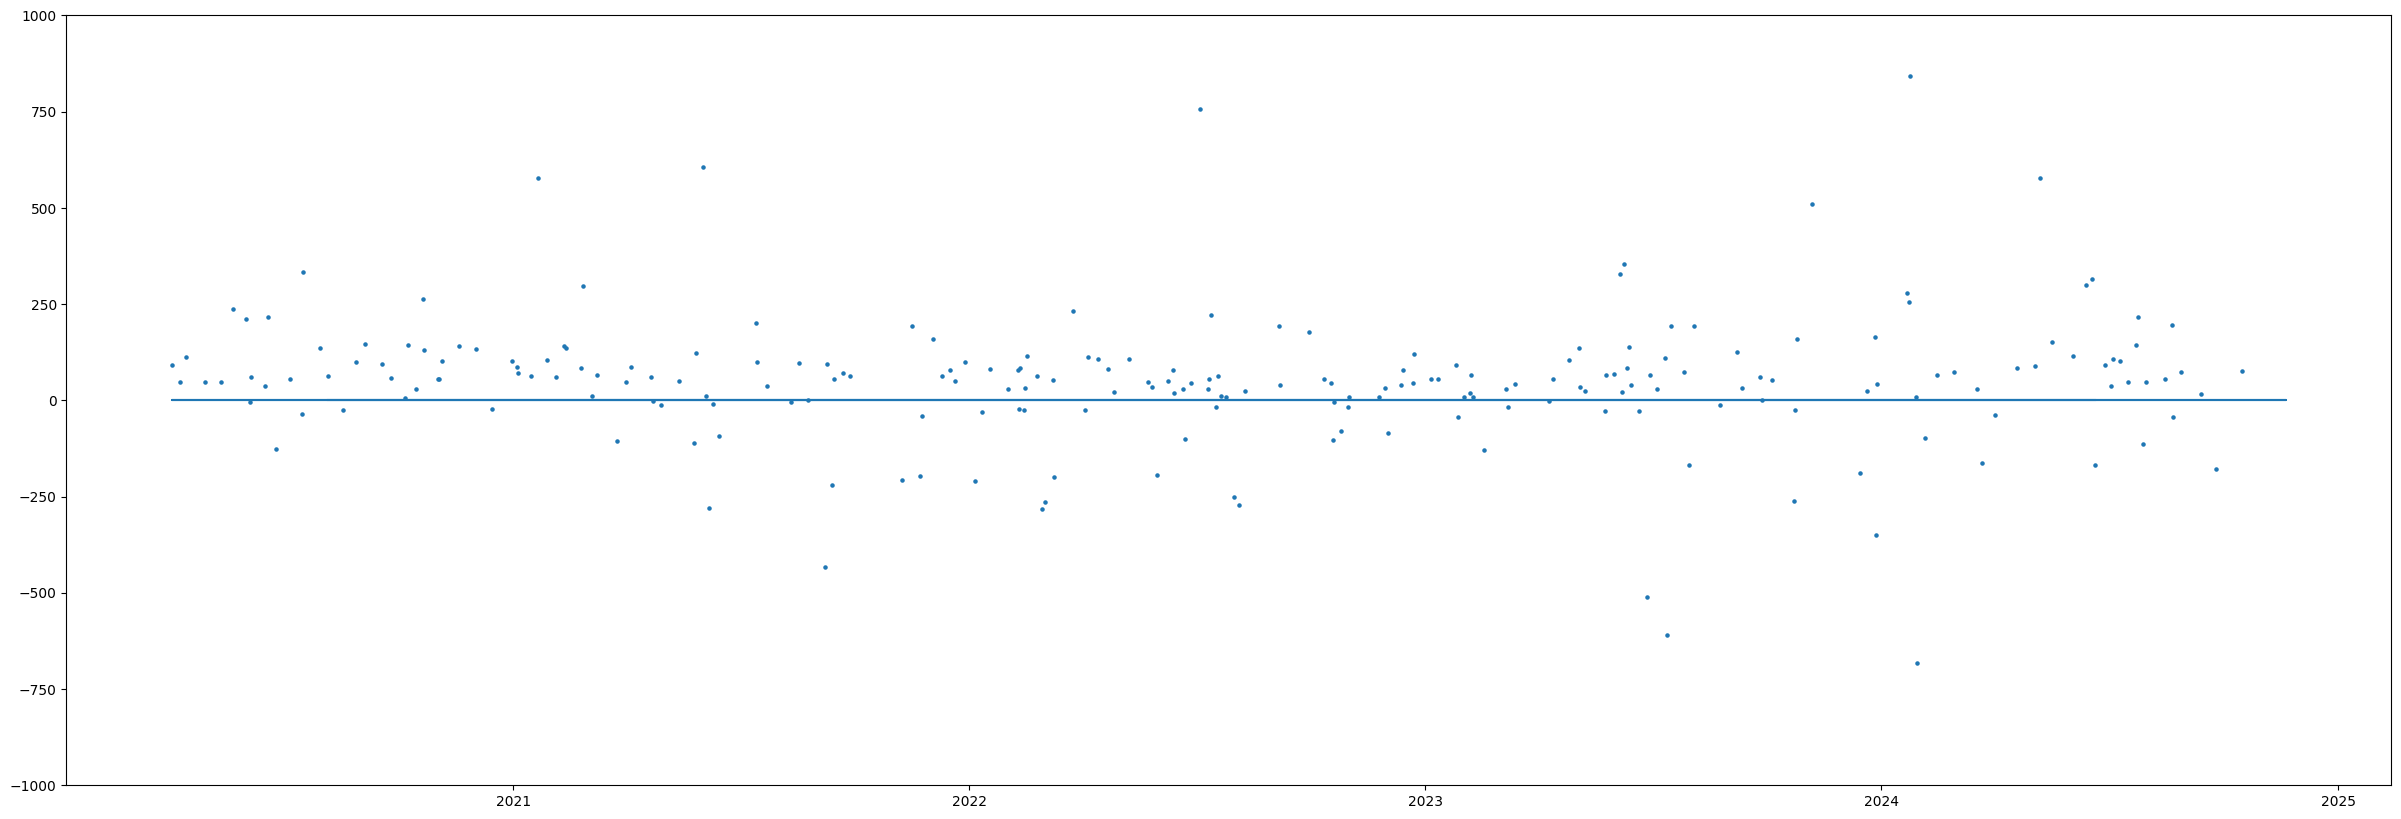

In [ ]:
df['Zeroaxes'] = df['Diff'].apply(lambda x: 0 if x>0 else 0) # pour avoir la ligne y=0

fig = plt.figure(1, figsize=(30, 10))
plt.scatter(df.index,df['Diff'],s=5)
plt.plot(df.index,df['Zeroaxes'])
plt.ylim(-1000, 1000)
# si le point est au dessus de y=0 la prédiction est dans le bon sens (hausse ou baisse), proche de y=100 alors elle est exacte

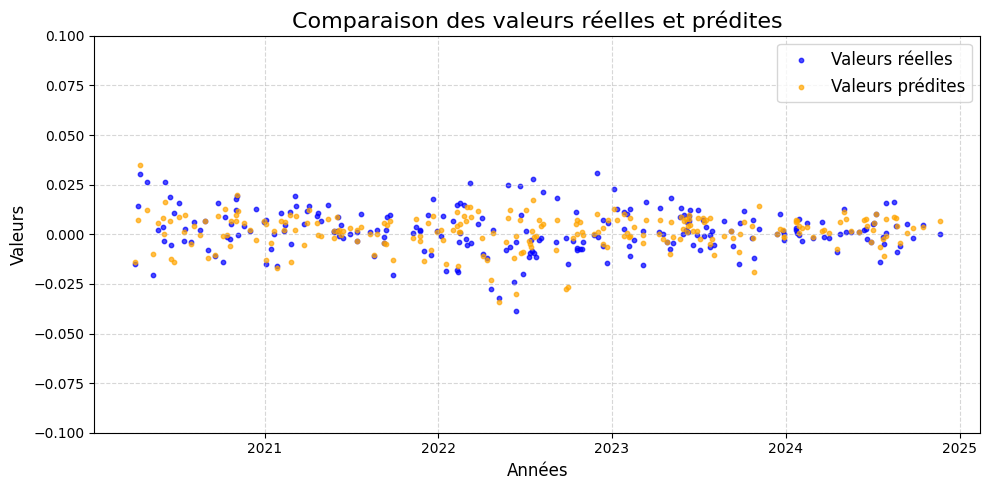

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(df.index, df['Real'], s=10, alpha=0.7, label='Valeurs réelles', color='blue')
ax.scatter(df.index, df['Fitted'], s=10, alpha=0.7, label='Valeurs prédites', color='orange')

ax.set_title('Comparaison des valeurs réelles et prédites', fontsize=16)
ax.set_xlabel('Années', fontsize=12)
ax.set_ylabel('Valeurs', fontsize=12)
ax.set_ylim(-0.10, 0.10)
ax.legend(fontsize=12)
ax.grid(True, linestyle='--', alpha=0.5) #grille

plt.tight_layout()
plt.show()

# Partie 3 : Analyse des Résultats et Interprétation

**Random Forest classifier**

In [ ]:
model1.fit(X_train, Y_train)

score1 = model1.score(X_test, Y_test)
print(f"Accuracy (simple score): {score1:.4f}")

Y_pred = model1.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Matrice de confusion
conf_matrix = confusion_matrix(Y_test, Y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Scores
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

class_report = classification_report(Y_test, Y_pred)
print("\nClassification Report:")
print(class_report)


Accuracy (simple score): 0.4255
Accuracy: 0.4255

Confusion Matrix:
[[28 75]
 [60 72]]

Precision: 0.4898
Recall: 0.5455
F1-Score: 0.5161

Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.27      0.29       103
           1       0.49      0.55      0.52       132

    accuracy                           0.43       235
   macro avg       0.40      0.41      0.40       235
weighted avg       0.41      0.43      0.42       235



**Performance globale plutôt faible:**

L'accuracy de 49.58% est proche du hasard, ce qui indique que le modèle a besoin d'améliorations.

Le modèle semble légèrement favorisé pour prédire des hausses (classe 1) au détriment des baisses (classe 0).

**Sources potentielles d'erreurs:**

Données non représentatives: Les indicateurs utilisés peuvent être insuffisants pour différencier efficacement les classes.     
Corrélation des variables: Des corrélations entre les variables pourraient limiter la capacité du modèle.


**Pistes d'amélioration**

Ajout de variables explicatives en intégrant davantage de facteurs macroéconomiques ou des indicateurs techniques plus spécifiques.

Optimisation des hyperparamètres: en ajustant les paramètres du Random Forest (
𝑛
estimators
,
max depth
,
min samples split
n
estimators
​
,max depth,min samples split) pour trouver une meilleure configuration.

Test d'autres modèles comme le Gradient Boosting qui pourrait mieux capter les variations des données.

**Gradient Boosting classifier**

In [ ]:
Y_pred_gb = model2.predict(X_test)

accuracy_gb = accuracy_score(Y_test, Y_pred_gb)
print(f"Accuracy: {accuracy_gb:.4f}")

# Matrice de confusion
conf_matrix_gb = confusion_matrix(Y_test, Y_pred_gb)
print("\nConfusion Matrix:")
print(conf_matrix_gb)

# Scores
precision_gb = precision_score(Y_test, Y_pred_gb)
recall_gb = recall_score(Y_test, Y_pred_gb)
f1_gb = f1_score(Y_test, Y_pred_gb)

print(f"\nPrecision: {precision_gb:.4f}")
print(f"Recall: {recall_gb:.4f}")
print(f"F1-Score: {f1_gb:.4f}")

class_report_gb = classification_report(Y_test, Y_pred_gb)
print("\nClassification Report:")
print(class_report_gb)


Accuracy: 0.5021

Confusion Matrix:
[[34 69]
 [48 84]]

Precision: 0.5490
Recall: 0.6364
F1-Score: 0.5895

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.33      0.37       103
           1       0.55      0.64      0.59       132

    accuracy                           0.50       235
   macro avg       0.48      0.48      0.48       235
weighted avg       0.49      0.50      0.49       235



L'accuracy (45.76%) et les scores faibles (F1-score, précision, rappel) montrent que le modèle ne capture pas correctement les patterns des données.
Le modèle a une légère préférence pour prédire la hausse (classe 1), mais reste imprécis dans les deux cas.

Bien qu’il y ait un équilibre relatif entre les classes (103 baisses vs 133 hausses), le modèle semble biaisé.
De plus, la complexité des interactions avec des variables explicatives utilisées (comme les indicateurs technique et la volatilité) pourraient ne pas être suffisantes pour capturer toute la complexité des données.

Les résultats actuels ne semblent pas produire des performances satisfaisantes afin de les exploiter de manière fiable.

**Gradient Boosting regressor**

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Y1_pred = model3.predict(X1_test)

mae = mean_absolute_error(Y1_test, Y1_pred)
mse = mean_squared_error(Y1_test, Y1_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y1_test, Y1_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Mean Absolute Error (MAE): 0.0057
Mean Squared Error (MSE): 0.0001
Root Mean Squared Error (RMSE): 0.0074
R-squared (R²): 0.5260


L'erreur moyenne de 0.0056 suggère que les prédictions du modèle sont assez proches des valeurs réelles en moyenne, ce qui est un bon résultat avec les données cibles de faible amplitude.

Pour ce qui est de notre faible valeur du MSE, cela indique que les grandes erreurs sont bien contrôlées et que le modèle est performant globalement.

L'erreur moyenne quadratique est de 0.75%, ce qui est faible pour des retours financiers.

Le R² indique que 51.08% de la variance des rendements du SP500 est expliquée par le modèle. Bien qu'un score supérieur à 0.5 montre une certaine qualité du modèle, cela laisse une part importante de la variance inexpliquée (environ 49%).

On peut donc en conclure que ce modèle semble bien capter les tendances globales des rendements, mais il ne capture pas complètement la variabilité des retours, en partie parce que les données financières ont tendance à être assez bruitées.

## Stratégie: Achat/Vente en fct de la prédiction du Gradient Boosting Classifier

In [ ]:
# On utilise le Gradient Boosting classifier
# Pas de frais de transaction

data_invest = Clean.loc[X.index]
data_invest['SP500_returns'][0] =0 # on démarre à 0
data_invest['Model'] = model2.predict(X)
data_invest = data_invest[['SP500','SP500_returns','Model','Predictor']]

#Wealth index du SP500
data_invest['wealth_index_SP500'] = 1+data_invest['SP500_returns']
data_invest['wealth_index_SP500'] = data_invest['wealth_index_SP500'].cumprod()*100

#Wealth index de la Stratégie utilisant de gradient Boosting
data_invest['Wealth_Strat'] = 1+data_invest['SP500_returns']*data_invest['Model'].shift(1)
data_invest['Wealth_Strat'] = data_invest['Wealth_Strat'].cumprod()*100


<ipython-input-35-628e8ead903b>:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data_invest['SP500_returns'][0] =0 # on démarre à 0
<ipython-input-35-628e8ead903b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

<Axes: >

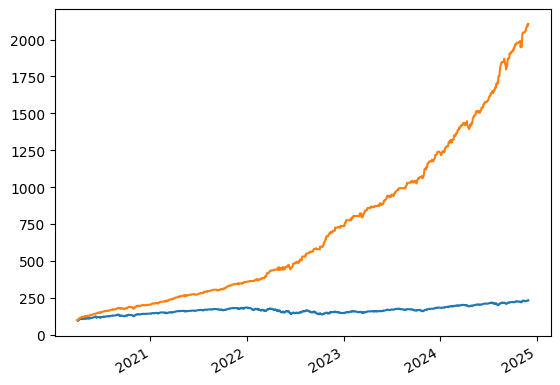

In [ ]:
data_invest['wealth_index_SP500'].plot()
data_invest['Wealth_Strat'].plot()

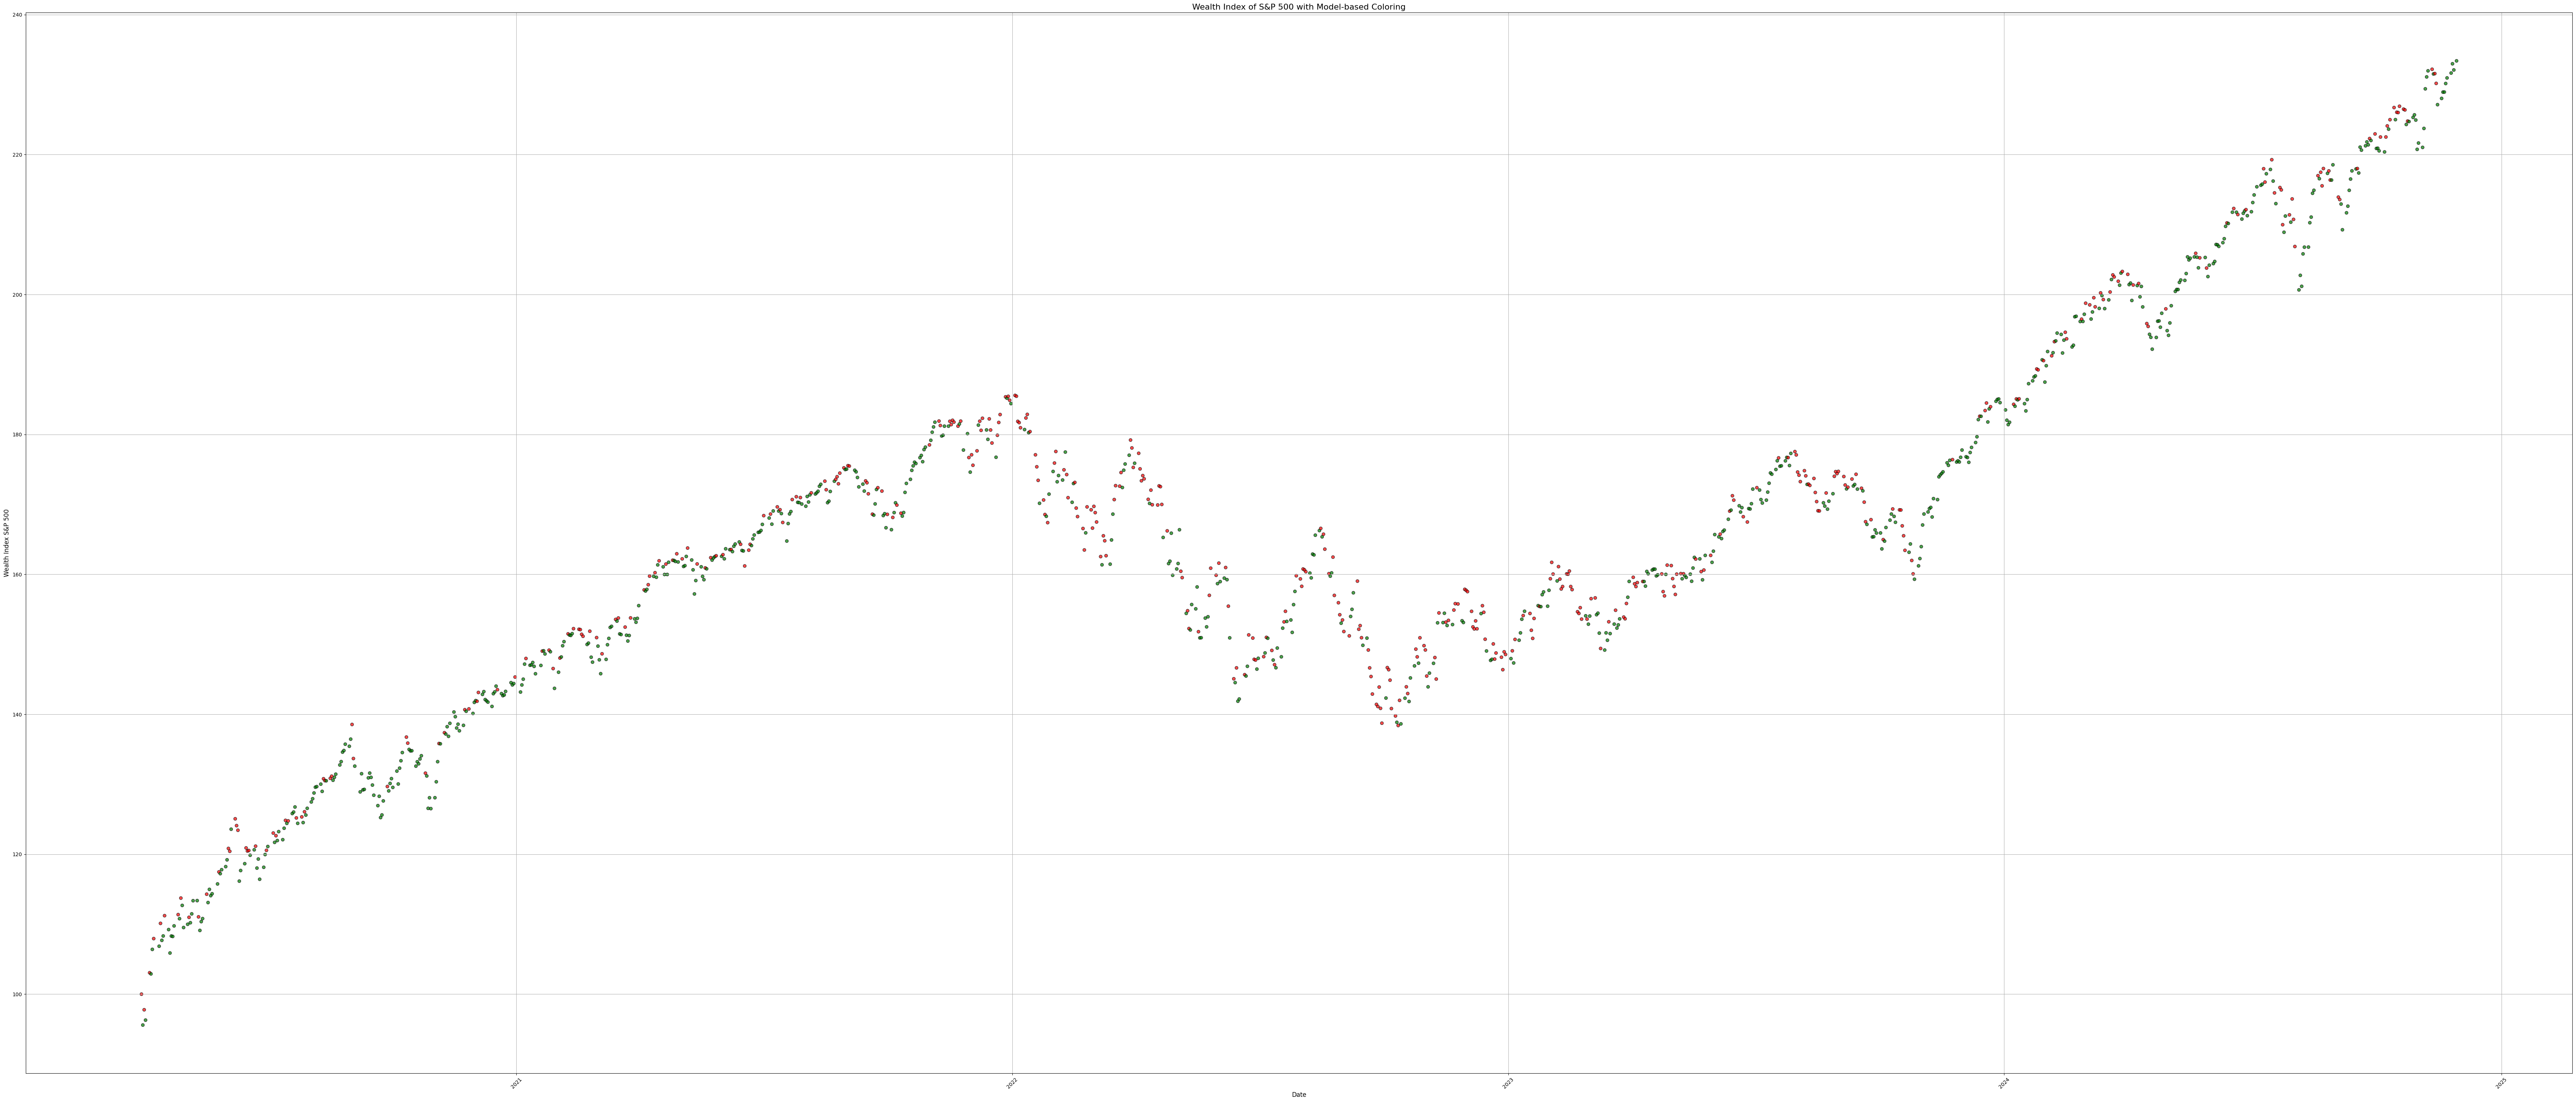

In [ ]:
# Plot le wealth index du SP500 avec les point rouge si la strat vend et vert sinon

plt.figure(figsize=(70, 30))

# Plot data: Use a condition to assign colors based on 'Model'
plt.scatter(data_invest.index, data_invest['wealth_index_SP500'],
            c=data_invest['Model'].map({1: 'green', 0: 'red'}),
            label='Wealth Index', edgecolors='black', alpha=0.7)

plt.title("Wealth Index of S&P 500 with Model-based Coloring", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Wealth Index S&P 500", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()